In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

In [101]:
class MEC_ENV(gym.Env):
    def __init__(self,n_users):
#         super(MEC_ENV).__init__()
        self.n_users = n_users
        self.action_space = spaces.Discrete(2**self.n_users)
        
        high = np.array([np.inf,1,1])
        low = np.array([0,0,0])
        self.observation_space = spaces.Box(low=low,high=high,dtype=np.float32)
        
        self.simga_loc = np.zeros(n_users)
        self.f_local = np.zeros(n_users)
        self.R = np.zeros(n_users)
        self.P_upload = np.zeros(n_users)
        self.S = np.zeros(n_users)
        self.C = np.zeros(n_users)
        self.D_max = np.zeros(n_users)
        self.P_wait = np.zeros(n_users)
        self.beta = np.zeros(n_users)
        self.theta = np.zeros(n_users)
        self.fmec = 100
        
        self.reset()
        
    def reset(self):
        self.state = np.array([np.inf,1,1])
        self.simga_loc = np.random.randint(1,3,self.n_users)*1e-4
        self.P_upload = np.random.randint(1,3,self.n_users)*1e-5
        self.P_wait = np.random.randint(1,3,self.n_users)*1e-6
        self.D_max = np.random.randint(1,3,self.n_users)*1e-2
        self.R = np.random.randint(1,3,self.n_users)*1e3
        self.f_local = np.random.randint(1,3,self.n_users)*1e6
        self.beta = np.random.randint(1,3,self.n_users)*0.05
        self.theta = np.random.randint(1,3,self.n_users)*0.05
        
        return self.state
    def step(self,action):
        
        
        num_calculate = np.random.randint(1,self.n_users)
        is_calcutate = np.random.choice(np.arange(self.n_users),num_calculate,replace=False)

        for i in is_calcutate:
            self.S[i] = np.random.randint(1e3,1e3+100,1)
            self.C[is_calcutate] = np.random.randint(1e3,1e3+100,1)
            

        
        
        E = 0
        for i in is_calcutate:
            if (self.C[i]/self.f_local[i]) > self.D_max[i]:action[i]=1
            if action[i]==1:
                
                E+=(self.P_upload[i]*self.S[i]/self.R[i]+self.P_wait[i]*self.C[i]/self.beta[i]*self.fmec)
            else:
                E+=self.C[i]*self.simga_loc[i]
        
        E = min(E,10)
        free_calculate = 1 - action[is_calcutate].dot(self.theta[is_calcutate])
        free_frequency = 1 - action[is_calcutate].dot(self.beta[is_calcutate])
        self.state = np.array([E,free_calculate,free_frequency])
        reward = -E
        
        
        return self.state,reward,False,{}
        # calculate E
            
            
        

In [102]:
mec = MEC_ENV(5)


In [103]:
action = np.random.randint(0,2,mec.n_users)
action[4]

1

In [104]:
mec.step(action)


(array([2.02601081, 0.9       , 0.95      ]), -2.02601081, False, {})

In [105]:
mec.theta

array([0.1 , 0.1 , 0.05, 0.1 , 0.1 ])

In [106]:
mec.beta

array([0.1 , 0.05, 0.05, 0.1 , 0.05])

# Q_learning

In [107]:
class q_learning(object):
    def __init__(self,env):
        self.env = env
        self.q_table = np.random.uniform(low=-1, high=1, size=(10*10*10,2**env.n_users))
        self.state_bins = self.bins(0,10,10)
        self.free_calculate_bins = self.bins(0,1,10)
        self.free_frequency_bins = self.bins(0,1,10)
        
    def bins(self,clip_min, clip_max, num):
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]
    
    
    def digitize_state(self,observation):
        # 将矢量打散回4个连续特征值
        state,free_calculate_bins,free_frequency_bins = observation
        # 分别对各个连续特征值进行离散化（分箱处理）
        digitized = [np.digitize(state, bins=self.state_bins),
                    np.digitize(free_calculate_bins, bins=self.free_calculate_bins),
                    np.digitize(free_frequency_bins, bins=self.free_frequency_bins)]
        # 将4个离散值再组合为一个离散值，作为最终结果
        return sum([x * (10 ** i) for i, x in enumerate(digitized)])
    
    def run(self):
        alpha = 0.1
        gamma = 0.9
        epsilon = 0.1

        step_rewards= []
        for eposide in range(500):
            eposide_r = []
            state = self.env.reset()
            state = self.digitize_state(state)

            for i in range(500):
                

                



                if np.random.uniform(0, 1) < epsilon:
                    action = np.random.randint(0,32) # Explore action space
                else:
                    action = np.argmax(self.q_table[state]) # Exploit learned values

                
                discrete_action = bin(action)[2:]
                while len(discrete_action)<self.env.n_users:
                    discrete_action = '0'+discrete_action
                discrete_action = np.array([int(i) for i in discrete_action[::-1]])


                next_state, reward, done, info = self.env.step(discrete_action) 
                next_state = self.digitize_state(next_state)

                eposide_r.append(reward)


                old_value = self.q_table[state, action]
                next_max = np.max(self.q_table[next_state])

                new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
                self.q_table[state, action] = new_value

                state = next_state

            step_rewards.append(sum(eposide_r))




        print("Training finished.\n")
        return step_rewards

Training finished.



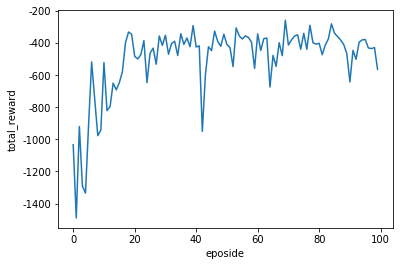

In [108]:
ql = q_learning(mec)
eposide_reward = ql.run()
plt.plot(list(range(500)),eposide_reward)
plt.xlabel('eposide')
plt.ylabel('total_reward')
plt.show()

array([0, 0])

# dqn


In [17]:
import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)


# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            action_dim,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + action_dim+1))

        # consist of [target_net, evaluate_net]
        self._build_net()

        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='eval_net')

        with tf.variable_scope('soft_replacement'):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ all inputs ------------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input State
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')  # input Next State
        self.r = tf.placeholder(tf.float32, [None, ], name='r')  # input Reward
        self.a = tf.placeholder(tf.int32, [None, ], name='a')  # input Action

        w_initializer, b_initializer = tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)

        # ------------------ build evaluate_net ------------------
        with tf.variable_scope('eval_net'):
            e1 = tf.layers.dense(self.s, 20, tf.nn.relu, kernel_initializer=w_initializer,
                                 bias_initializer=b_initializer, name='e1')
            self.q_eval = tf.layers.dense(e1, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='q')

        # ------------------ build target_net ------------------
        with tf.variable_scope('target_net'):
            t1 = tf.layers.dense(self.s_, 20, tf.nn.relu, kernel_initializer=w_initializer,
                                 bias_initializer=b_initializer, name='t1')
            self.q_next = tf.layers.dense(t1, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='t2')

        with tf.variable_scope('q_target'):
            q_target = self.r + self.gamma * tf.reduce_max(self.q_next, axis=1, name='Qmax_s_')    # shape=(None, )
            self.q_target = tf.stop_gradient(q_target)
        with tf.variable_scope('q_eval'):
            a_indices = tf.stack([tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a], axis=1)
            self.q_eval_wrt_a = tf.gather_nd(params=self.q_eval, indices=a_indices)    # shape=(None, )
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval_wrt_a, name='TD_error'))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s, a, r, s_))
        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.target_replace_op)
            print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        _, cost = self.sess.run(
            [self._train_op, self.loss],
            feed_dict={
                self.s: batch_memory[:, :self.n_features],
                self.a: batch_memory[:, self.n_features],
                self.r: batch_memory[:, self.n_features + 1],
                self.s_: batch_memory[:, -self.n_features:],
            })

        self.cost_his.append(cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()



In [18]:
env = MEC_ENV(5)
RL  = DeepQNetwork(env.n_users,env.action_space.n, env.observation_space.shape[0],
                      learning_rate=0.01,
                      reward_decay=0.9,
                      e_greedy=0.9,
                      replace_target_iter=200,
                      memory_size=2000,
                      # output_graph=True
                      )

In [19]:


def run(env,RL):
    step_reward= []
    for episode in range(500):
        # initial observation
        observation = env.reset()
        eposide_reward = []
        for step in range(500):
           
            # RL choose action based on observation
            action = RL.choose_action(observation)
            action = bin(action)[2:]
            while len(action)<env.n_users:
                action = '0'+action
            action = np.array([int(i) for i in action[::-1]])

            # RL take action and get next observation and reward
            observation_, reward, done,_= env.step(action)
            
            eposide_reward.append(reward)
            RL.store_transition(observation, action, reward, observation_)

            if (step > 200) and (step % 5 == 0):
                RL.learn()

            # swap observation
            observation = observation_
        step_reward.append(sum(eposide_reward))  
            # break while loop when end of this episode
            
    
    return step_reward


if __name__ == "__main__":
    # maze game
    
    
    step_reward = run(env,RL)
    plt.plot(list(range(500)),step_reward)
    plt.xlabel('eposide')
    plt.ylabel('total_reward')
    plt.show()


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced



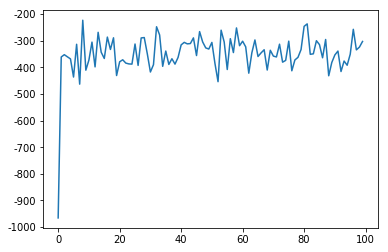

In [89]:
plt.plot(list(range(500)),eposide_reward)
plt.xlabel('eposide')
plt.ylabel('total_reward')
plt.show()

In [111]:
def run_compare(env):
    step_rewards= []
    for eposide in range(500):
        eposide_r = []
        
        for i in range(500):

            action = np.ones(env.n_users)
            next_state, reward, done, info = env.step(action) 
            

            eposide_r.append(reward)


            state = next_state

        step_rewards.append(sum(eposide_r))




    print("Training finished.\n")
    return step_rewards

# 对比实验（方案3）

In [79]:
#beta是计算资源
#theta是通信资源
class MEC_ENV_compare3(gym.Env):
    def __init__(self,n_users):
#         super(MEC_ENV).__init__()
        self.n_users = n_users
        self.action_space = spaces.Discrete(2**self.n_users)
        
        high = np.array([np.inf,1,1])
        low = np.array([0,0,0])
        self.observation_space = spaces.Box(low=low,high=high,dtype=np.float32)
        
        self.simga_loc = np.zeros(n_users)
        self.f_local = np.zeros(n_users)
        self.R = np.zeros(n_users)
        self.P_upload = np.zeros(n_users)
        self.S = np.zeros(n_users)
        self.C = np.zeros(n_users)
        self.D_max = np.zeros(n_users)
        self.P_wait = np.zeros(n_users)
        self.beta = np.zeros(n_users)
        self.theta = np.zeros(n_users)
        self.fmec = 100
        
        self.reset()
        
    def reset(self):
        self.state = np.array([np.inf,1,1])
        self.simga_loc = np.random.randint(1,3,self.n_users)*1e-4
        self.P_upload = np.random.randint(1,3,self.n_users)*1e-5
        self.P_wait = np.random.randint(1,3,self.n_users)*1e-6
        self.D_max = np.random.randint(1,3,self.n_users)*1e-2
        self.R = np.random.randint(1,3,self.n_users)*1e3
        self.f_local = np.random.randint(1,3,self.n_users)*1e6
        self.beta = np.ones(self.n_users)*0.1
        self.theta = np.ones(self.n_users)*0.1
        
        return self.state
    def step(self,action):
        
        #尽可能本地计算
        num_local = np.random.randint(self.n_users-2,self.n_users)
        index = np.random.choice(np.arange(self.n_users),num_local,replace=False)
        action[index] =0
        
        num_calculate = np.random.randint(1,self.n_users)
        is_calcutate = np.random.choice(np.arange(self.n_users),num_calculate,replace=False)

        for i in is_calcutate:
            self.S[i] = np.random.randint(1e3,1e3+100,1)
            self.C[is_calcutate] = np.random.randint(1e3,1e3+100,1)
            

        
        
        E = 0
        for i in is_calcutate:
            if (self.C[i]/self.f_local[i]) > self.D_max[i]:action[i]=1
            if action[i]==1:
                
                E+=(self.P_upload[i]*self.S[i]/self.R[i]+self.P_wait[i]*self.C[i]/self.beta[i]*self.fmec)
            else:
                E+=self.C[i]*self.simga_loc[i]
        
        E = min(E,10)
        free_calculate = 1 - action[is_calcutate].dot(self.theta[is_calcutate])
        free_frequency = 1 - action[is_calcutate].dot(self.beta[is_calcutate])
        self.state = np.array([E,free_calculate,free_frequency])
        reward = -E
        
        
        return self.state,reward,False,{}
        # calculate E
            
            
            


Training finished.



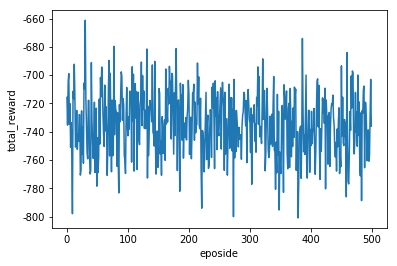

In [113]:
mec_3 = MEC_ENV_compare3(5)
eposide_reward = run_compare(mec_3)
plt.plot(list(range(500)),eposide_reward)
plt.xlabel('eposide')
plt.ylabel('total_reward')
plt.show()

# 对比试验(方案4）

In [114]:
#beta是计算资源
#theta是通信资源
class MEC_ENV_compare4(gym.Env):
    def __init__(self,n_users):
#         super(MEC_ENV).__init__()
        self.n_users = n_users
        self.action_space = spaces.Discrete(2**self.n_users)
        
        high = np.array([np.inf,1,1])
        low = np.array([0,0,0])
        self.observation_space = spaces.Box(low=low,high=high,dtype=np.float32)
        
        self.simga_loc = np.zeros(n_users)
        self.f_local = np.zeros(n_users)
        self.R = np.zeros(n_users)
        self.P_upload = np.zeros(n_users)
        self.S = np.zeros(n_users)
        self.C = np.zeros(n_users)
        self.D_max = np.zeros(n_users)
        self.P_wait = np.zeros(n_users)
        self.beta = np.zeros(n_users)
        self.theta = np.zeros(n_users)
        self.fmec = 100
        
        self.reset()
        
    def reset(self):
        self.state = np.array([np.inf,1,1])
        self.simga_loc = np.random.randint(1,3,self.n_users)*1e-4
        self.P_upload = np.random.randint(1,3,self.n_users)*1e-5
        self.P_wait = np.random.randint(1,3,self.n_users)*1e-6
        self.D_max = np.random.randint(1,3,self.n_users)*1e-2
        self.R = np.random.randint(1,3,self.n_users)*1e3
        self.f_local = np.random.randint(1,3,self.n_users)*1e6
        self.beta = np.ones(self.n_users)*0.1
        self.theta = np.ones(self.n_users)*0.1
        
        return self.state
    def step(self,action):
        
        #尽可能卸载计算
        num_local = np.random.randint(self.n_users-2,self.n_users)
        index = np.random.choice(np.arange(self.n_users),num_local,replace=False)
        action[index] =1
        
        num_calculate = np.random.randint(1,self.n_users)
        is_calcutate = np.random.choice(np.arange(self.n_users),num_calculate,replace=False)

        for i in is_calcutate:
            self.S[i] = np.random.randint(1e3,1e3+100,1)
            self.C[is_calcutate] = np.random.randint(1e3,1e3+100,1)
            

        
        
        E = 0
        for i in is_calcutate:
            if (self.C[i]/self.f_local[i]) > self.D_max[i]:action[i]=1
            if action[i]==1:
                
                E+=(self.P_upload[i]*self.S[i]/self.R[i]+self.P_wait[i]*self.C[i]/self.beta[i]*self.fmec)
            else:
                E+=self.C[i]*self.simga_loc[i]
        
        E = min(E,10)
        free_calculate = 1 - action[is_calcutate].dot(self.theta[is_calcutate])
        free_frequency = 1 - action[is_calcutate].dot(self.beta[is_calcutate])
        self.state = np.array([E,free_calculate,free_frequency])
        reward = -E
        
        
        return self.state,reward,False,{}
        # calculate E
            
            
        

Training finished.



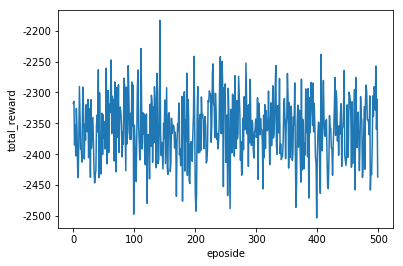

In [115]:
mec_4 = MEC_ENV_compare4(5)
eposide_reward = run_compare(mec_4)
plt.plot(list(range(500)),eposide_reward)
plt.xlabel('eposide')
plt.ylabel('total_reward')
plt.show()

# 对比试验(方案5）

In [116]:
#beta是计算资源
#theta是通信资源
class MEC_ENV_compare5(gym.Env):
    def __init__(self,n_users):
#         super(MEC_ENV).__init__()
        self.n_users = n_users
        self.action_space = spaces.Discrete(2**self.n_users)
        
        high = np.array([np.inf,1,1])
        low = np.array([0,0,0])
        self.observation_space = spaces.Box(low=low,high=high,dtype=np.float32)
        
        self.simga_loc = np.zeros(n_users)
        self.f_local = np.zeros(n_users)
        self.R = np.zeros(n_users)
        self.P_upload = np.zeros(n_users)
        self.S = np.zeros(n_users)
        self.C = np.zeros(n_users)
        self.D_max = np.zeros(n_users)
        self.P_wait = np.zeros(n_users)
        self.beta = np.zeros(n_users)
        self.theta = np.zeros(n_users)
        self.fmec = 100
        
        self.reset()
        
    def reset(self):
        self.state = np.array([np.inf,1,1])
        self.simga_loc = np.random.randint(1,3,self.n_users)*1e-4
        self.P_upload = np.random.randint(1,3,self.n_users)*1e-5
        self.P_wait = np.random.randint(1,3,self.n_users)*1e-6
        self.D_max = np.random.randint(1,3,self.n_users)*1e-2
        self.R = np.random.randint(1,3,self.n_users)*1e3
        self.f_local = np.random.randint(1,3,self.n_users)*1e6
        self.beta = np.ones(self.n_users)*0.1
        self.theta = np.ones(self.n_users)*0.1
        
        return self.state
    def step(self,action):
        
        #随机本地和卸载计算
        action = np.random.randint(0,2,self.n_users)
        
        
        num_calculate = np.random.randint(1,self.n_users)
        is_calcutate = np.random.choice(np.arange(self.n_users),num_calculate,replace=False)

        for i in is_calcutate:
            self.S[i] = np.random.randint(1e3,1e3+100,1)
            self.C[is_calcutate] = np.random.randint(1e3,1e3+100,1)
            

        
        
        E = 0
        for i in is_calcutate:
            if (self.C[i]/self.f_local[i]) > self.D_max[i]:action[i]=1
            if action[i]==1:
                
                E+=(self.P_upload[i]*self.S[i]/self.R[i]+self.P_wait[i]*self.C[i]/self.beta[i]*self.fmec)
            else:
                E+=self.C[i]*self.simga_loc[i]
        
        E = min(E,10)
        free_calculate = 1 - action[is_calcutate].dot(self.theta[is_calcutate])
        free_frequency = 1 - action[is_calcutate].dot(self.beta[is_calcutate])
        self.state = np.array([E,free_calculate,free_frequency])
        reward = -E
        
        
        return self.state,reward,False,{}
        # calculate E
            
            
        

Training finished.



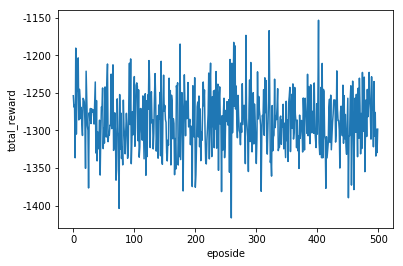

In [117]:
mec_5 = MEC_ENV_compare5(5)
eposide_reward = run_compare(mec_5)
plt.plot(list(range(500)),eposide_reward)
plt.xlabel('eposide')
plt.ylabel('total_reward')
plt.show()